# Classification using ```pytorch``` - Neural Network Classifier

We first begin by loading in all of the same packages as we did in notebook [4a - Logistic Regression](classroom_04a.ipynb).

What we'll see is the code is actually _exactly_ the same throughout this notebook as it was in the previous example. The only difference is the way that define the model class using ```pytorch```.

In [1]:
# system tools
import os

# pytorch
import torch
import torch.nn as nn

# data processing
import pandas as pd
import numpy as np

# huggingface datasets
from datasets import load_dataset

# scikit learn tools
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

# plotting tools
import matplotlib.pyplot as plt


__Creating a model class__



In [2]:
class Model(nn.Module):
    def __init__(self, n_input_features=10):
        super().__init__()
        self.linear1 = nn.Linear(n_input_features, 30)
        self.linear2 = nn.Linear(30, 30)
        self.linear3 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred

## Load data


In [3]:
# load the sst2 dataset
dataset = load_dataset("glue", "sst2")
# select the train split
data = dataset["train"]
X = data["sentence"]
y = data["label"]

/home/coder/.local/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Found cached dataset glue (/home/coder/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]


## Create document representations


In [4]:
# vectorizer
vectorizer = CountVectorizer()
# vectorized training data
X_vect = vectorizer.fit_transform(X)
# to tensors
X_vect = torch.tensor(X_vect.toarray(), dtype=torch.float)
y = torch.tensor(list(y), dtype=torch.float)
y = y.view(y.shape[0], 1)


## Initialize parameters


In [5]:
# initialize model
n_samples, n_features = X_vect.shape
model = Model(n_input_features=n_features)

# define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters())

## Train


In [7]:
# train
epochs = 100
print("[INFO:] Training classifier...")
loss_history = []
for epoch in range(epochs):
    # forward
    y_hat = model(X_vect)

    # backward
    loss = criterion(y_hat, y)
    loss_history.append(loss)

    # backpropagation
    loss.backward()
    # take step, reset
    optimizer.step()
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

print("[INFO:] Finished training!")

[INFO:] Training classifier...
epoch: 10, loss = 0.6351
epoch: 20, loss = 0.6192
epoch: 30, loss = 0.5996
epoch: 40, loss = 0.5760
epoch: 50, loss = 0.5487
epoch: 60, loss = 0.5183
epoch: 70, loss = 0.4859
epoch: 80, loss = 0.4529
epoch: 90, loss = 0.4207
epoch: 100, loss = 0.3903
[INFO:] Finished training!


## Evaluate


In [8]:
# Plot
predicted = model(X_vect).detach().numpy()
print(classification_report(y, 
                            np.where(predicted > 0.5, 1, 0),
                            target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.90      0.84      0.87     29780
    Positive       0.88      0.93      0.90     37569

    accuracy                           0.89     67349
   macro avg       0.89      0.88      0.89     67349
weighted avg       0.89      0.89      0.89     67349



## Plot loss history

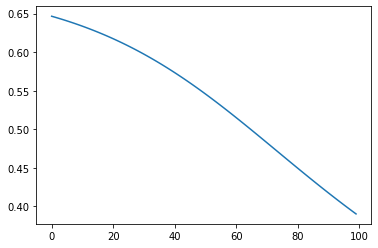

In [9]:
loss_H = [val.item() for val in loss_history]
fig, ax = plt.subplots()
ax.plot(loss_H)